In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR, QSVR
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression
from qiskit.opflow.gradients import Gradient
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

algorithm_globals.random_seed = 42

In [54]:
data = load_diabetes(return_X_y=False)

In [55]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [56]:
data.feature_names 

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [57]:
data_df = pd.DataFrame(data=data.data, columns=data.feature_names)
data_df['progression'] = data.target

In [58]:
data_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [59]:
data_df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


In [60]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          442 non-null    float64
 1   sex          442 non-null    float64
 2   bmi          442 non-null    float64
 3   bp           442 non-null    float64
 4   s1           442 non-null    float64
 5   s2           442 non-null    float64
 6   s3           442 non-null    float64
 7   s4           442 non-null    float64
 8   s5           442 non-null    float64
 9   s6           442 non-null    float64
 10  progression  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [61]:
data_df.isna().sum()

age            0
sex            0
bmi            0
bp             0
s1             0
s2             0
s3             0
s4             0
s5             0
s6             0
progression    0
dtype: int64

In [62]:
corr = data_df.corr()
corr

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


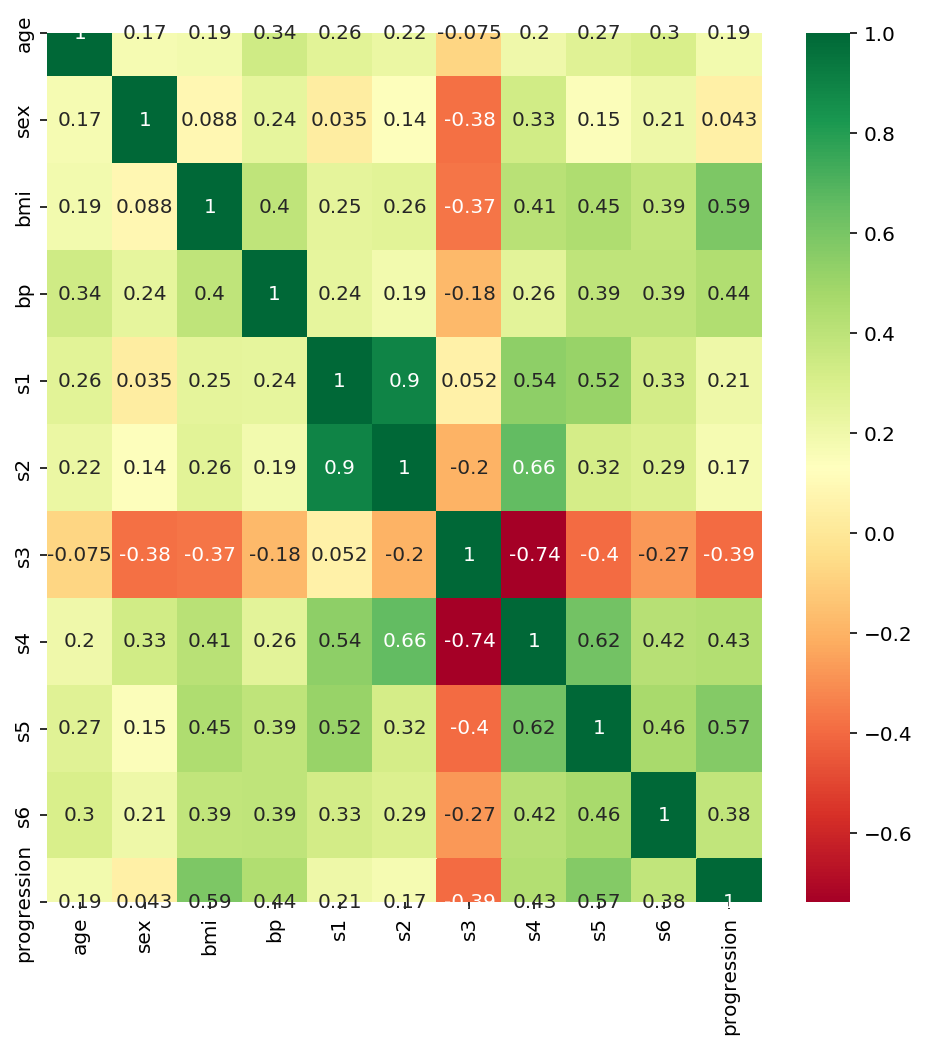

In [63]:
plt.subplots(figsize=(8,8))
sns.heatmap(corr,cmap= 'RdYlGn',annot=True)
plt.show()

In [64]:
X_data = data_df.drop(labels='progression', axis=1)
Y_data = data_df['progression']

In [65]:
X_data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [66]:
X_data.shape

(442, 10)

In [67]:
Y_data.head()

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: progression, dtype: float64

In [68]:
Y_data.shape

(442,)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_data.values, Y_data.values, test_size=0.2, random_state=algorithm_globals.random_seed)

In [70]:
X_train[:10]

array([[ 0.07076875,  0.05068012,  0.01211685,  0.05630106,  0.03420581,
         0.04941617, -0.03971921,  0.03430886,  0.02736771, -0.0010777 ],
       [-0.00914709,  0.05068012, -0.01806189, -0.03321358, -0.0208323 ,
         0.01215151, -0.07285395,  0.07120998,  0.00027149,  0.01963284],
       [ 0.00538306, -0.04464164,  0.04984027,  0.09761551, -0.01532849,
        -0.016345  , -0.00658447, -0.00259226,  0.01703713, -0.01350402],
       [-0.02730979, -0.04464164, -0.03530688, -0.02977071, -0.05660707,
        -0.05862005,  0.03023191, -0.03949338, -0.04986847, -0.12948301],
       [-0.02367725, -0.04464164, -0.06548562, -0.08141377, -0.03871969,
        -0.05360967,  0.05968501, -0.0763945 , -0.03712835, -0.04249877],
       [ 0.00175052, -0.04464164, -0.03961813, -0.10092337, -0.02908802,
        -0.03012354,  0.04495846, -0.05019471, -0.06832974, -0.12948301],
       [ 0.01628068, -0.04464164,  0.02073935,  0.02187235, -0.01395254,
        -0.01321352, -0.00658447, -0.00259226

## Classical analysis

In [71]:
lm = LinearRegression()

In [72]:
lm.fit(X_train, y_train)

LinearRegression()

In [73]:
predicted_y = lm.predict(X_test)
predicted_y

array([139.5483133 , 179.52030578, 134.04133298, 291.41193598,
       123.78723656,  92.17357677, 258.23409704, 181.33895238,
        90.22217862, 108.63143298,  94.13938654, 168.43379636,
        53.50669663, 206.63040068, 100.13238561, 130.66881649,
       219.53270758, 250.78291772, 196.36682356, 218.57497401,
       207.35002447,  88.48361667,  70.43428801, 188.95725301,
       154.88720039, 159.35957695, 188.31587948, 180.38835506,
        47.98988446, 108.97514644, 174.78080029,  86.36598906,
       132.95890535, 184.5410226 , 173.83298051, 190.35863287,
       124.41740796, 119.65426903, 147.95402494,  59.05311211,
        71.62636914, 107.68722902, 165.45544477, 155.00784964,
       171.04558668,  61.45763075,  71.66975626, 114.96330486,
        51.57808027, 167.57781958, 152.52505798,  62.95827693,
       103.49862017, 109.20495627, 175.63844013, 154.60247734,
        94.41476124, 210.74244148, 120.25601864,  77.61590087,
       187.93503183, 206.49543321, 140.63018684, 105.59

# Quantum Regressor

## Regression with an OpflowQNN

In [74]:
data_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


In [75]:
X_data_qnn = data_df.drop(['progression'], axis = 1).values
Y_data_qnn = data_df['progression'].values

X_train_qnn, X_test_qnn, y_train_qnn, y_test_qnn = train_test_split(X_data_qnn, Y_data_qnn, test_size=0.2, random_state=algorithm_globals.random_seed)

In [76]:
X_test_qnn.shape

(89, 10)

In [77]:
Y_data_qnn.shape

(442,)

In [78]:
X_data_qnn.shape

(442, 10)

In [79]:
quantum_instance = QuantumInstance(
    Aer.get_backend("aer_simulator"),
    shots=1024,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

In [80]:
features = X_data_qnn.shape[1]
features

10

In [81]:
# construct simple feature map
params = [Parameter(str(i)) for i in list(range(0, features))]

feature_map = QuantumCircuit(features, name="fm")

for i in list(range(0, features)):
    feature_map.ry(params[i], i)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(features, name="vf")
ansatz.ry(param_y, 0)

# construct QNN
regression_opflow_qnn = TwoLayerQNN(features, feature_map, ansatz, quantum_instance=quantum_instance)

In [82]:
Y_data_qnn[:10]

array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310.])

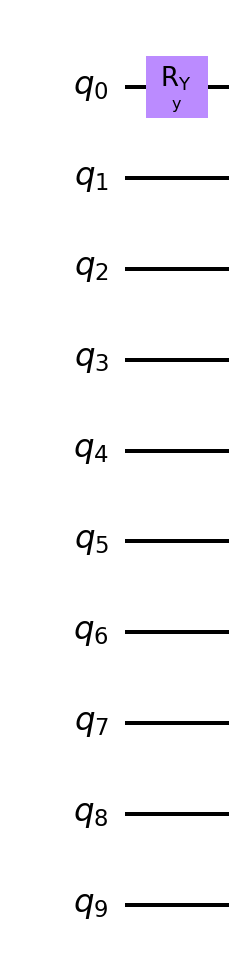

In [83]:
ansatz.draw('mpl')

In [84]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait = True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [85]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn,
    loss="squared_error", #"absolute_error",
    optimizer=L_BFGS_B(maxiter=5),
    #optimizer=COBYLA(maxiter=20),
    callback=callback_graph,
)

In [86]:
X_train_qnn[:5]

array([[ 0.07076875,  0.05068012,  0.01211685,  0.05630106,  0.03420581,
         0.04941617, -0.03971921,  0.03430886,  0.02736771, -0.0010777 ],
       [-0.00914709,  0.05068012, -0.01806189, -0.03321358, -0.0208323 ,
         0.01215151, -0.07285395,  0.07120998,  0.00027149,  0.01963284],
       [ 0.00538306, -0.04464164,  0.04984027,  0.09761551, -0.01532849,
        -0.016345  , -0.00658447, -0.00259226,  0.01703713, -0.01350402],
       [-0.02730979, -0.04464164, -0.03530688, -0.02977071, -0.05660707,
        -0.05862005,  0.03023191, -0.03949338, -0.04986847, -0.12948301],
       [-0.02367725, -0.04464164, -0.06548562, -0.08141377, -0.03871969,
        -0.05360967,  0.05968501, -0.0763945 , -0.03712835, -0.04249877]])

In [87]:
y_train_qnn[:10]

array([144., 150., 280., 125.,  59.,  65., 281., 277., 167.,  90.])

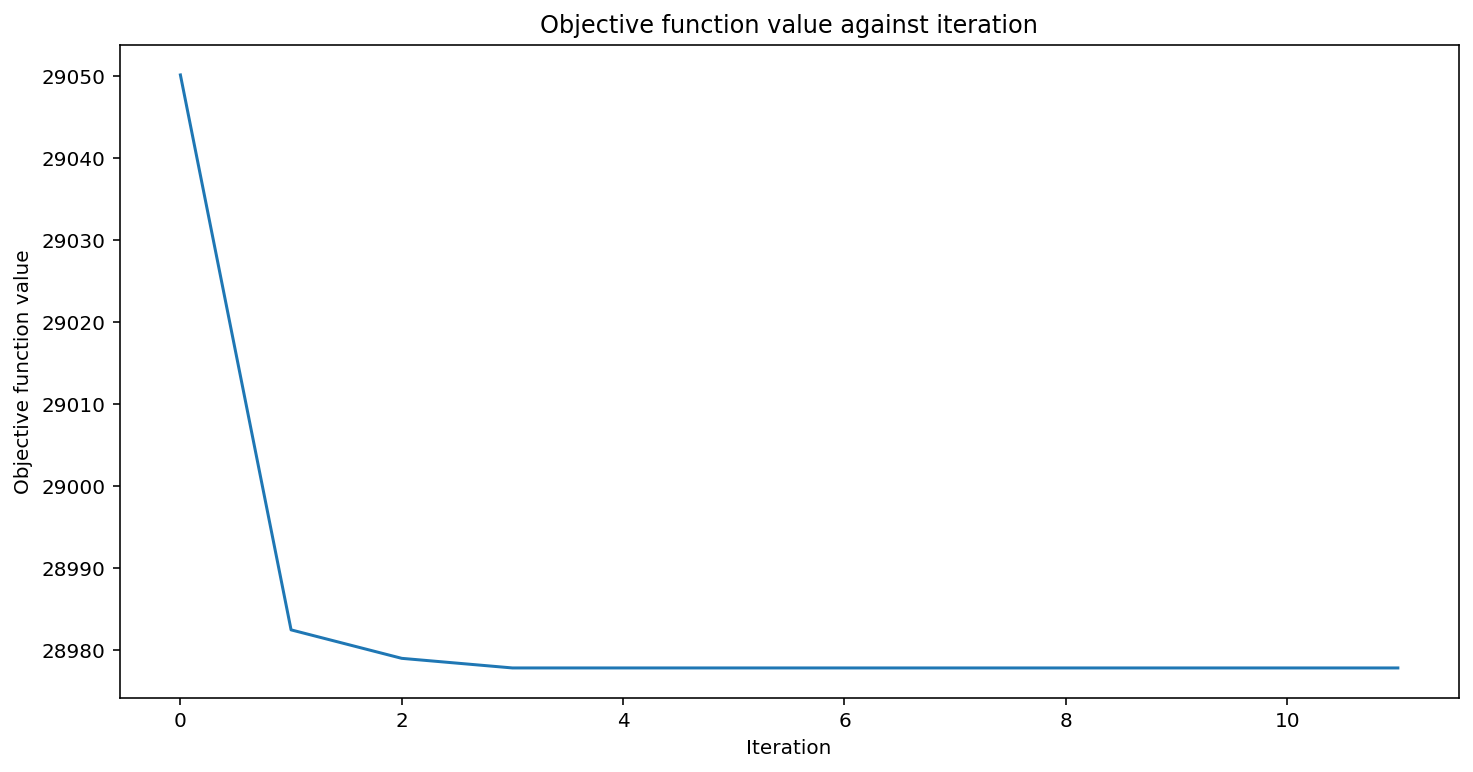

In [88]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

X_data_qnn = MinMaxScaler().fit_transform(X_data_qnn)

# fit to data
regressor.fit(X_data_qnn, Y_data_qnn)

In [89]:
X_data_qnn[:5]

array([[0.66666667, 1.        , 0.58264463, 0.54929577, 0.29411765,
        0.25697211, 0.20779221, 0.28208745, 0.56221737, 0.43939394],
       [0.48333333, 0.        , 0.14876033, 0.35211268, 0.42156863,
        0.30677291, 0.62337662, 0.14104372, 0.22244301, 0.16666667],
       [0.88333333, 1.        , 0.51652893, 0.43661972, 0.28921569,
        0.25896414, 0.24675325, 0.28208745, 0.49658437, 0.40909091],
       [0.08333333, 0.        , 0.30165289, 0.30985915, 0.49509804,
        0.44721116, 0.23376623, 0.42313117, 0.57293604, 0.46969697],
       [0.51666667, 0.        , 0.20661157, 0.54929577, 0.46568627,
        0.41733068, 0.38961039, 0.28208745, 0.36236911, 0.33333333]])

In [90]:
Y_data_qnn[:5]

array([151.,  75., 141., 206., 135.])

In [91]:
regressor.score(X_data_qnn, Y_data_qnn)

-3.886746759129503

In [50]:
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X_data_qnn, Y_data_qnn)

-3.886746782157328

In [52]:
pred = regressor.predict(X_data_qnn)
pred[:10]

array([[0.26367188],
       [0.63671875],
       [0.29296875],
       [0.43359375],
       [0.52734375],
       [0.66601562],
       [0.375     ],
       [0.15234375],
       [0.24609375],
       [0.4609375 ]])

## Regression with the Variational Quantum Regressor (VQR)

In [43]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

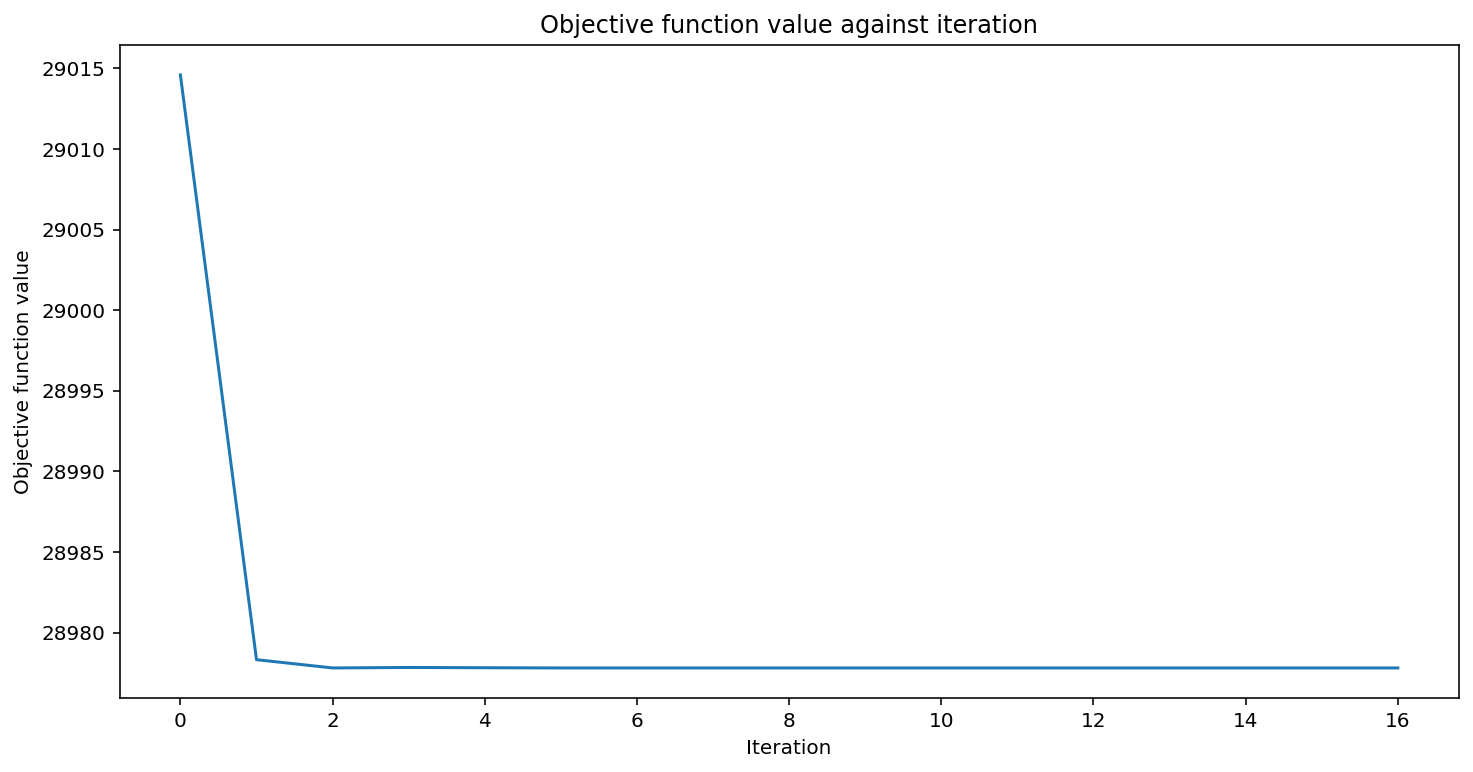

In [44]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
plt.show()

# fit regressor
vqr.fit(X_data_qnn, Y_data_qnn)

In [45]:
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X_data_qnn, Y_data_qnn)

-3.886741695504008

## Quantum Support Vector Regressor

In [46]:
qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

qsvr = QSVR(quantum_kernel=qkernel)
qsvr.fit(X_data_qnn, Y_data_qnn)

QSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
     max_iter=-1,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000028A95D595C8>,
     shrinking=True, tol=0.001, verbose=False)

In [47]:
qsvr.predict(X_data_qnn)

array([144.55861742, 126.6528836 , 141.46852193, 140.45126618,
       135.88214563, 126.99048391, 128.9420101 , 142.63255306,
       140.85511505, 142.93494972, 128.14275963, 136.75746504,
       132.66704718, 140.35695793, 131.08916243, 147.52133413,
       143.73088634, 147.3188393 , 136.03852909, 132.08451243,
       132.06830158, 129.41134343, 132.28234265, 157.44684585,
       136.74867345, 137.83387706, 127.85270949, 139.07871239,
       133.04256222, 141.98172348, 136.50016716, 125.01518066,
       153.15824963, 129.86118745, 127.62441643, 131.60985343,
       142.94679049, 135.93810177, 154.74619561, 137.22745837,
       145.35059994, 126.19598589, 136.7188179 , 130.41897823,
       149.49347932, 136.34651175, 132.30425721, 128.97667556,
       131.58958567, 144.49686558, 138.07254097, 141.37830649,
       136.9562458 , 141.33759036, 136.39817259, 127.90012609,
       142.21241402, 124.92096255, 129.71158329, 141.73053922,
       128.78075506, 142.96334812, 127.69240547, 132.04

In [48]:
score = qsvr.score(X_data_qnn, Y_data_qnn)
score

0.10957051072519541

#### https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html